In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y=mnist["data"], mnist["target"]
print(f"X shape: {X.shape}\n\ny Shape: {y.shape}")

X shape: (70000, 784)

y Shape: (70000,)


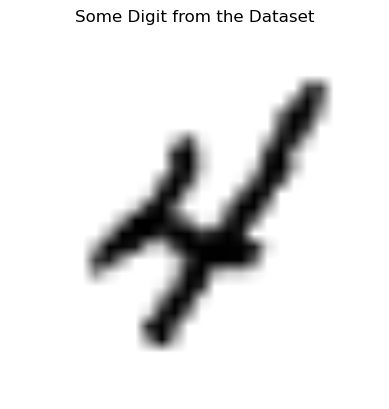

In [4]:
digit=X[9]
image=digit.reshape(28,28)

plt.title("Some Digit from the Dataset")
plt.imshow(image, cmap=mpl.cm.binary, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
y[9]

'4'

In [6]:
#change y from string to integers
y=y.astype(np.uint8)
y[9]

4

In [7]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure digits_plot


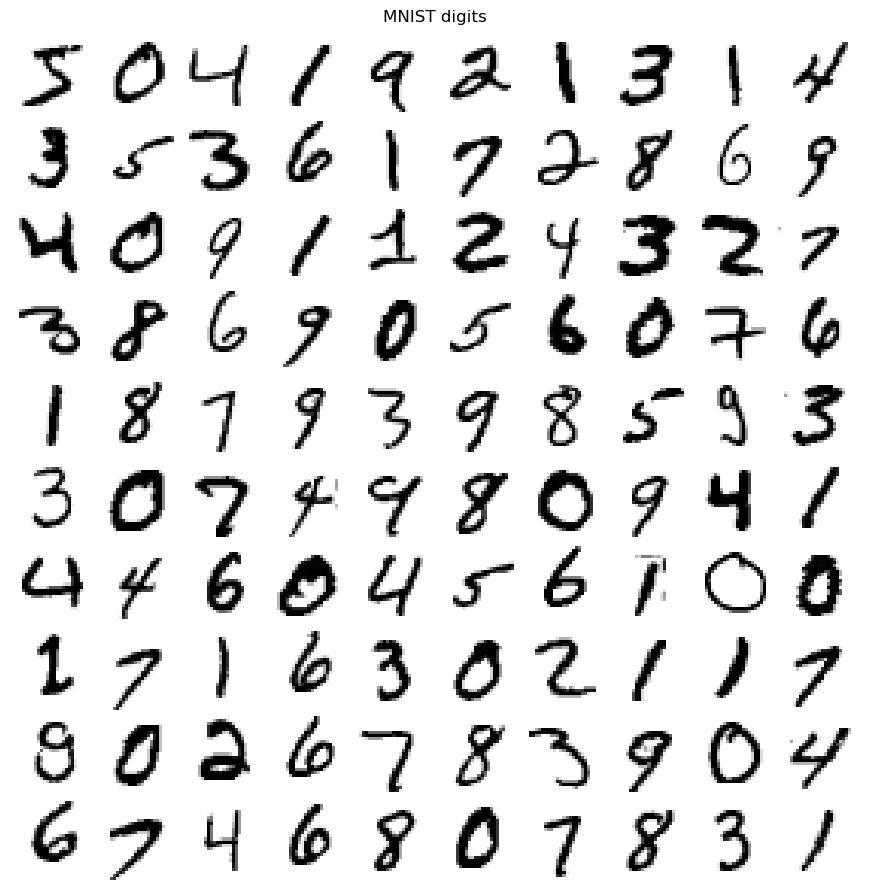

In [8]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.title("MNIST digits")
save_fig("digits_plot")
plt.show();

In [9]:
X_train, X_test, y_train, y_test= X[:60000], X[60000:], y[:60000], y[60000:]

### Binary Classifier

In [10]:
trainy_4=(y_train==4)
testy_4=(y_test==4)

- Stochastic Gradient Descent (SGD)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd=SGDClassifier(random_state=42)
sgd.fit(X_train, trainy_4)

SGDClassifier(random_state=42)

In [12]:
sgd.predict([digit])

array([ True])

#### Performance Metrics

- Cross-Validation

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X_train, trainy_4):
    clonee=clone(sgd)
    X_train_fold=X_train[train_index]
    y_train_fold=trainy_4[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=trainy_4[test_index]
    
    clonee.fit(X_train_fold, y_train_fold)
    y_pred=clonee.predict(X_test_fold)
    correct=sum(y_pred== y_test_fold)
    print(correct/ len(y_pred)*100)

95.15833333333333
97.55
97.65833333333333
97.79166666666667
97.81666666666666


In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, trainy_4, cv=5, 
                scoring="accuracy")

array([0.97825   , 0.97225   , 0.96308333, 0.9725    , 0.97241667])

In [15]:
from sklearn.base import BaseEstimator

class Not4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
not4=Not4Classifier()
cross_val_score(not4, X_train, trainy_4, cv=5,
               scoring="accuracy")

array([0.90133333, 0.90308333, 0.90333333, 0.90433333, 0.90108333])

#### Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd, X_train, trainy_4, cv=5)

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(trainy_4, y_train_pred)

array([[53283,   875],
       [  823,  5019]], dtype=int64)

Saving figure Confusion Matrix 4


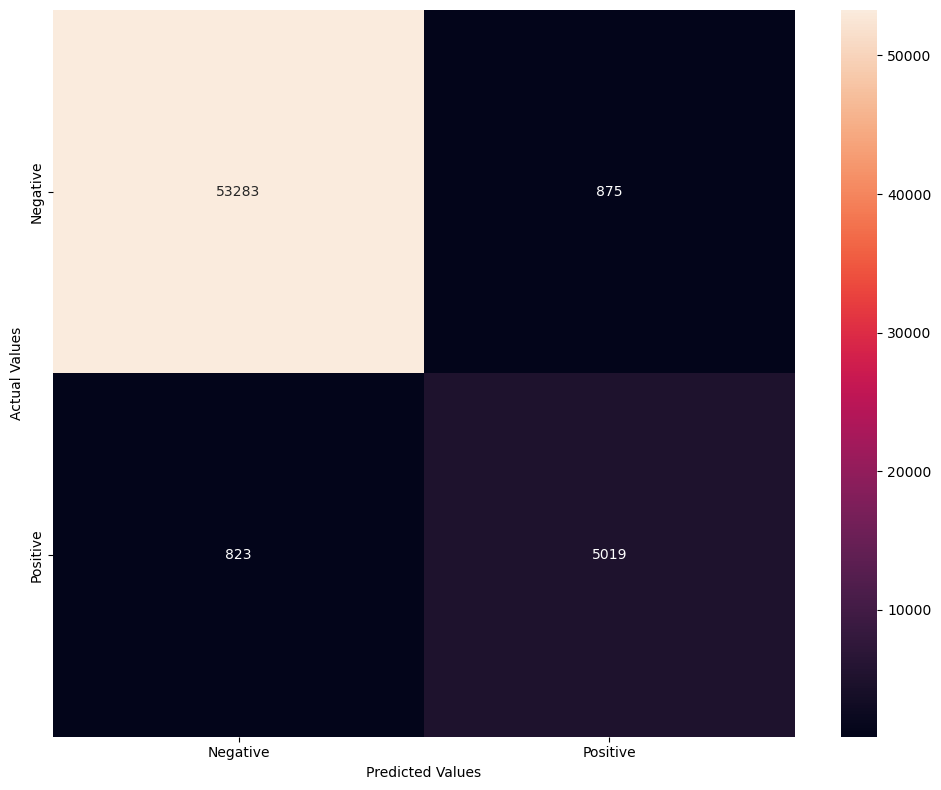

In [19]:
labels=["Negative", "Positive"]
cm=confusion_matrix(trainy_4, y_train_pred)

fig, ax=plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
plt.yticks(ticks=[0.5,1.5], labels=labels)
plt.ylabel("Actual Values")
plt.xticks(ticks=[0.5,1.5], labels=labels)
plt.xlabel("Predicted Values")
save_fig("Confusion Matrix 4")
plt.show();

#### Precision and Recall.

In [20]:
from sklearn.metrics import precision_score, recall_score

print(f"Precison Score: {precision_score(trainy_4, y_train_pred)}\n\nRecall Score: {recall_score(trainy_4, y_train_pred)}")

Precison Score: 0.8515439429928741

Recall Score: 0.8591235878123931


In [21]:
from sklearn.metrics import classification_report, f1_score

print(f"F1 Score: {f1_score(trainy_4, y_train_pred)}\n\nClassification Report: {classification_report(trainy_4, y_train_pred)}")

F1 Score: 0.8553169734151329

Classification Report:               precision    recall  f1-score   support

       False       0.98      0.98      0.98     54158
        True       0.85      0.86      0.86      5842

    accuracy                           0.97     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.97      0.97      0.97     60000



#### Precision and Recall Trade-off

In [22]:
y_scores=sgd.decision_function([digit])
y_scores

array([14090.84855953])

In [23]:
threshold= 0
y_digit_pred=(y_scores > threshold)
y_digit_pred

array([ True])

In [24]:
threshold=15000
y_digit_pred=(y_scores>threshold)
y_digit_pred

array([False])

In [25]:
y_scores=cross_val_predict(sgd, X_train, trainy_4, cv=5,
                          method="decision_function")

Saving figure precision_recall_vs_threshold_plot


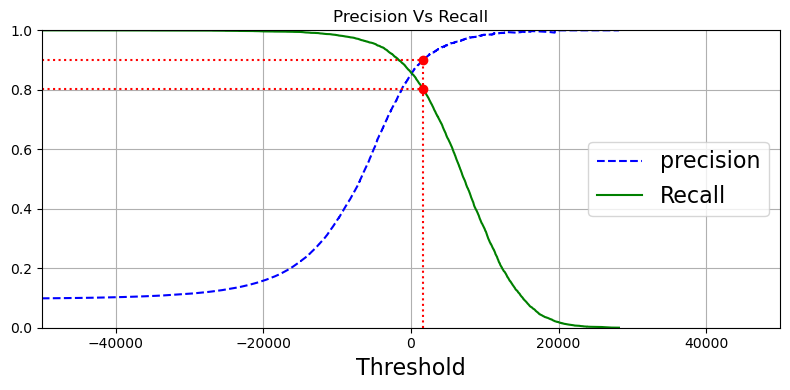

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds= precision_recall_curve(trainy_4, y_scores)

def plot(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.title("Precision Vs Recall")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))   
plot(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")
plt.show()
    

In [27]:
(y_train_pred==(y_scores>0)).all()

True

Saving figure Precision vs Recall


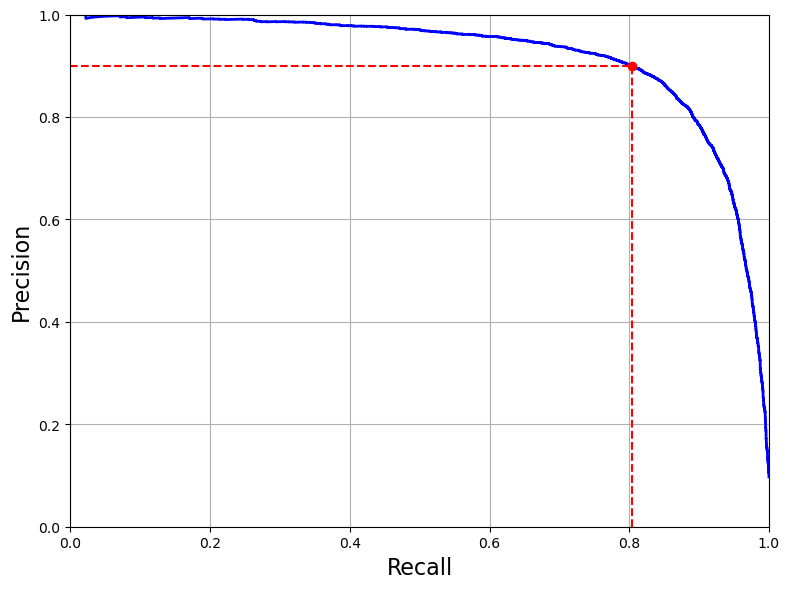

In [28]:
def plt_precall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0,1,0,1])
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plt_precall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0.,0.9], 'r--')
plt.plot([0.0, recall_90_precision], [0.9,0.9], "r--")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("Precision vs Recall")
plt.show()

In [29]:
threshold_90_precision=thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

1649.4900127962082

In [30]:
y_train_pred_90=(y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [31]:
precision_score(trainy_4, y_train_pred_90)


0.9001150306748467

In [32]:
recall_score(trainy_4, y_train_pred_90)

0.8036631290653886

#### ROC Curve
- Receiver Operating Characteristic, used with binary classifiers to plot the True Positive Rate (recall) against the False Positive rate.

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds=roc_curve(trainy_4, y_scores)

Saving figure roc_curve_plot


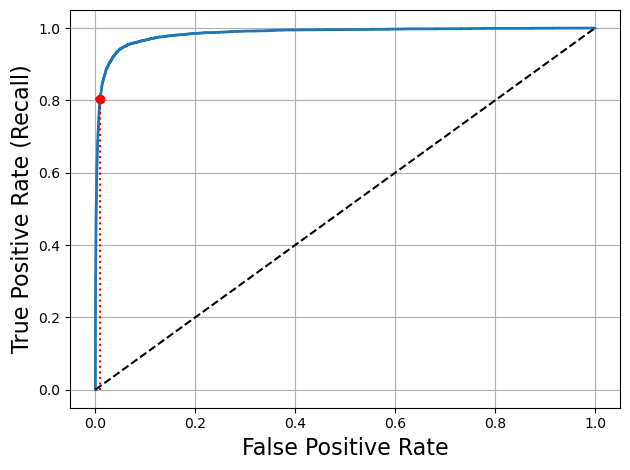

In [34]:
def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)
    
plot_roc(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot") 
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(trainy_4, y_scores)

0.9850546303088056

In [36]:
#train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier.
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=42)
probability=cross_val_predict(rf, X_train, trainy_4, cv=5,
                             method="predict_proba")

In [37]:
y_scores=probability[:, 1]
fpr_rf, tpr_rf, threshold_rf=roc_curve(trainy_4, y_scores)

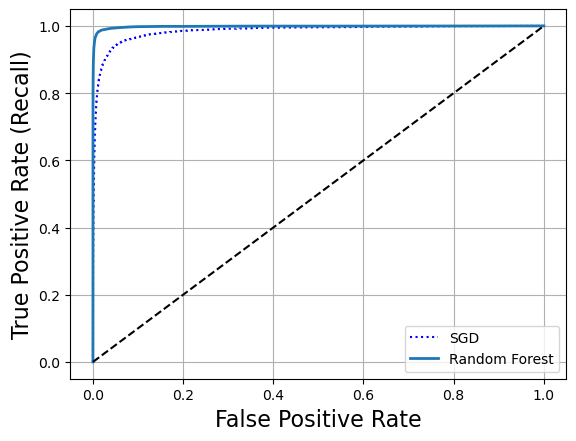

In [38]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc(fpr_rf, tpr_rf, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [39]:
roc_auc_score(trainy_4, y_scores)

0.9983251974939013

In [40]:
rf_trainy=cross_val_predict(rf, X_train,trainy_4, cv=5)
precision_score(trainy_4, rf_trainy)

0.9917402996542451

In [41]:
recall_score(trainy_4, rf_trainy)

0.8837726805888394

#### Multiclass Classification

In [42]:
sgd.fit(X_train, y_train)
sgd.predict([digit])

array([4], dtype=uint8)

In [43]:
digit_scores=sgd.decision_function([digit])
digit_scores

array([[-16343.28318658, -23384.59563255,  -6695.83888459,
         -8567.75254019,   8917.48038629,  -5477.45198286,
        -11951.14635095, -16492.51276695,  -2304.48278571,
         -9235.29452453]])

In [44]:
np.argmax(digit_scores)

4

In [46]:
sgd.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
sgd.classes_[4]

4

In [50]:
from sklearn.svm import SVC

svm=SVC(gamma="auto", random_state=42)
svm.fit(X_train[:1000], y_train[:1000])
svm.predict([digit])

array([4], dtype=uint8)

In [51]:
sc=svm.decision_function([digit])
sc

array([[ 3.82111996,  7.09167958,  4.83444983,  1.79943469,  9.29932174,
         0.79485736,  2.80437474,  8.10392157, -0.22417259,  5.84182891]])

In [52]:
np.argmax(sc)

4

- One-Versus-One Classifier.

In [48]:
from sklearn.multiclass import OneVsOneClassifier
ovo=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo.fit(X_train, y_train)
ovo.predict([digit])

array([4], dtype=uint8)

In [49]:
len(ovo.estimators_)

45

In [53]:
#Random Forest Classifier
rf.fit(X_train, y_train)
rf.predict([digit])

array([4], dtype=uint8)

In [54]:
rf.predict_proba([digit])

array([[0.  , 0.  , 0.  , 0.  , 0.98, 0.01, 0.  , 0.01, 0.  , 0.  ]])

In [55]:
cross_val_score(sgd, X_train, y_train, cv=5, scoring="accuracy")

array([0.88083333, 0.88325   , 0.88116667, 0.86625   , 0.8875    ])

In [56]:
#scaling inputs to increase the accuracy
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=5, scoring="accuracy")

array([0.89733333, 0.88725   , 0.89583333, 0.89233333, 0.90516667])

- One-Versus-all.

In [57]:
from sklearn.multiclass import OneVsRestClassifier
ovr=OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr.fit(X_train[:1000], y_train[:1000])
ovr.predict([digit])

array([4], dtype=uint8)

In [58]:
len(ovr.estimators_)

10

#### Error Analysis.

In [61]:
y_train_pred=cross_val_predict(sgd, X_train_scaled, y_train, cv=5)
cm=confusion_matrix(y_train, y_train_pred)
cm

array([[5570,    0,   15,    3,    9,   39,   33,    5,  248,    1],
       [   0, 6408,   41,   21,    3,   41,    4,    7,  208,    9],
       [  26,   25, 5220,   85,   67,   24,   62,   37,  401,   11],
       [  26,   18,  107, 5187,    0,  184,   24,   39,  483,   63],
       [  10,   13,   36,    9, 5183,   10,   34,   20,  381,  146],
       [  26,   18,   23,  155,   51, 4401,   77,   13,  596,   61],
       [  26,   17,   41,    2,   40,   83, 5548,    7,  154,    0],
       [  20,   11,   52,   23,   48,   11,    3, 5685,  217,  195],
       [  16,   58,   37,   88,    2,  119,   28,    8, 5459,   36],
       [  21,   19,   28,   58,  119,   30,    1,  170,  429, 5074]],
      dtype=int64)

Saving figure confusion Matrix 


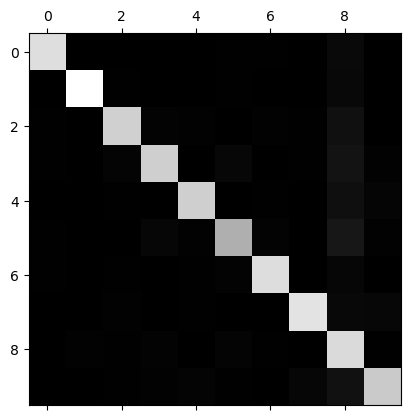

In [62]:
#image representation 
plt.matshow(cm, cmap=plt.cm.gray)
save_fig("confusion Matrix ")
plt.show()

In [63]:
row_sums=cm.sum(axis=1, keepdims=True)
norm_cm=cm/row_sums

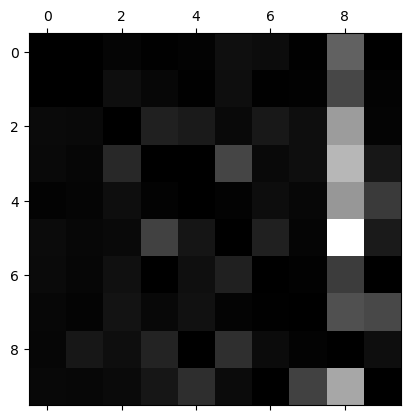

In [64]:
np.fill_diagonal(norm_cm, 0)
plt.matshow(norm_cm, cmap=plt.cm.gray)
plt.show()

Saving figure error_analysis plot


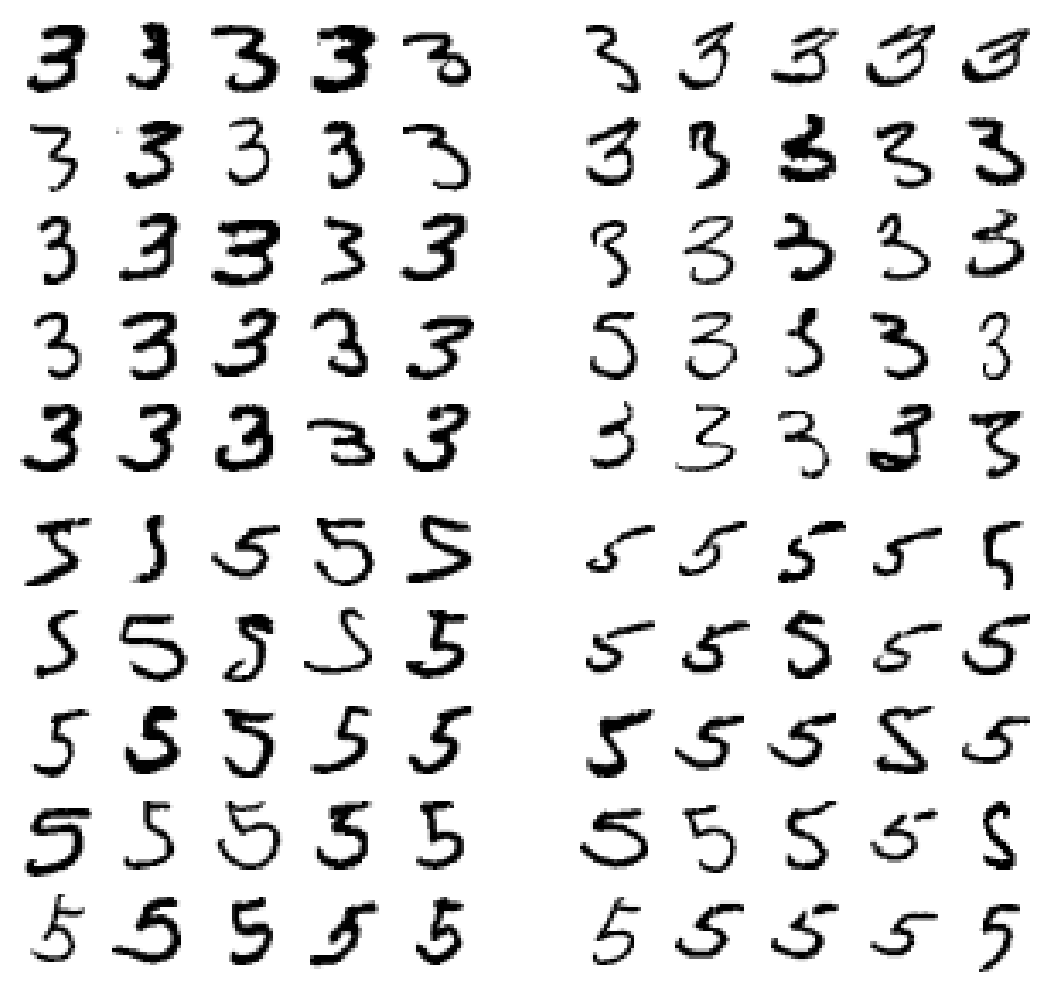

In [66]:
#analyze individual errors, take 3s and 5s
a, b= 3,5
X_aa=X_train[(y_train==a)&(y_train_pred==a)]
X_ab=X_train[(y_train==a)&(y_train_pred==b)]
X_ba=X_train[(y_train==b)&(y_train_pred==a)]
X_bb=X_train[(y_train==b)&(y_train_pred==b)]

plt.figure(figsize=(12,10))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis plot")
plt.show()

- On the left are images classified as 3s and on the right are the images classified as 5s.

#### Multilabel Classification.

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train % 2==1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn=KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [68]:
knn.predict([digit])

array([[False, False]])

In [ ]:
knn_pred=cross_val_predict(knn, X_train, y_multilabel, cv=5)
f1_score(y_multilabel,knn_pred, average="macro")

#### Multioutput Classification.

In [69]:
noise=np.random.randint(0, 100, (len(X_train), 784))
X_train_mod=X_train+noise
noise=np.random.randint(0, 100, (len(X_test), 784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

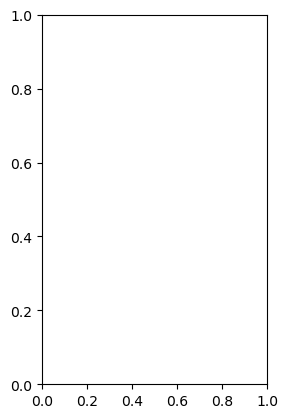

In [72]:
index=1
plt.subplot(121); plot_digits(X_test_mod[index])
plt.subplot(122); plot_digits(y_test_mod[index])
save_fig("Noisy Digit")
plt.show()

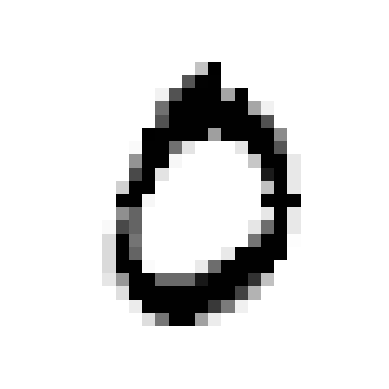

In [74]:
knn.fit(X_train_mod, y_train_mod)
clean_digit=knn.predict([X_test_mod[index]])
plot_digits(clean_digit)